##### Link Colab with Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
cd '/content/drive/My Drive/MLHC Project Resources/python_code/'

/content/drive/.shortcut-targets-by-id/107n_WmJFGDku3jDNPRYJskUDip3ElWv7/MLHC Project Resources/python_code


##### Load packages and model




In [3]:
#@markdown Load packages 
!pip install pydicom
from load_model import *
from utils import *
from PIL import Image
import torchvision
import pandas as pd
import torch
import cv2
import os
# import torch.nn.functional as F

     |████████████████████████████████| 35.3MB 89kB/s 


In [4]:
#@markdown Load model
model = load_model()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth



=> loading checkpoint
=> loaded checkpoint


In [0]:
#@markdown Set up transformers for pre-processing

normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
transformer = transforms.Compose([transforms.Resize(256),
                                  transforms.TenCrop(224),
                                  transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                  transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                ])

##### Load and Pre-Process MIMIC Image

In [0]:
#@markdown 1. Load images for one patient (may result in multiple images)
#@markdown 2. Pre-process
#@markdown 3. Save as .png

record_df = pd.read_csv('./record_list_subset.csv')

study_id = 53911762

record = record_df.loc[record_df.study_id == study_id]
image_paths = record.path
study_dict ={}
for (image_number, path) in enumerate(record.path):
    x = pydicom.dcmread(path)
    img = x.pixel_array

    img = cv2.resize(img, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC).astype(float)
    img = (np.maximum(img,0) / img.max()) * 255.0
    img = img.astype(int)

    cv2.imwrite(path.replace('.dcm', '.png'),img)

In [0]:
#@markdown Load one .png image as np.array. 

#@markdown Make sure its dimensions are (x, x, 3)
path = 'files/p10/p10000032/s53911762/fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818.png'

img = Image.open(path).convert('RGB')
img_np = np.array(img)

In [8]:
img_np.shape

(1024, 1024, 3)

##### Set up and run LIME

In [9]:
#@markdown Load packages
!pip install lime

from lime import lime_image
from skimage.segmentation import mark_boundaries

     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 2.0MB 11.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.0-cp36-none-any.whl size=284181 sha256=29c49d45942a2bfd0ef1506049defce3f4238cbd41d5a1117807c6ee8702ad55
  Stored in directory: /root/.cache/pip/wheels/22/f2/ec/e5ebd07348b2b1ac722e91c2f549fcc220f7d5f25497a61232
Successfully built lime
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [0]:
#@markdown Define functions necessary for running LIME:
#@markdown 1. `batch_image_predict` - classification function
#@markdown 2. `explain_instance` - runs LIME and prints visual explanation
def batch_image_predict(images):
    """
    Args:
        img_batch: list of 3-dimensional numpy array
    
    Global Variables:
        model: pre-trained model supplied by Alexandru
        transformer: pre-processing instance
    """
    pred_list = []

    for img in images:
      #convert np array to PIL.Image
      img_PIL = Image.fromarray(img).convert('RGB')

      #transform, outputs np array
      input_var = transformer(img_PIL)

      #predict, take the average of the predictions and save as np array
      output = model(input_var)
      output_mean = output.mean(0).detach().cpu().numpy()

      #store
      pred_list.append(output_mean)
    
    numpy_probs = np.stack(pred_list, axis=0)
    return numpy_probs

def explain_instance(img, img_diseases = None, num_samples = 5):
    """
    Args:
        img: the original 3-dimensional numpy array before transforming into torch tensor
        img_diseases: string of diseases for the image
        num_samples: 5 (the number of neighbours to consider)
    
    Global Variables:
        explainer: pre-defined explainer object
    """
    explanation = explainer.explain_instance(img,
                                             batch_image_predict,
                                             top_labels=1,      #explain the diagnosis with highest predicted prob
                                             num_samples=num_samples)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=False, 
                                                num_features=10, 
                                                hide_rest=False)
    img_boundry2 = mark_boundaries(temp, mask)
    plt.imshow(img_boundry2)
    plt.savefig(str(img) + ".png")
    files.download(str(img) + ".png")

    if img_diseases is not None:
        plt.title(f"Diseases: {img_diseases}")
        
    return

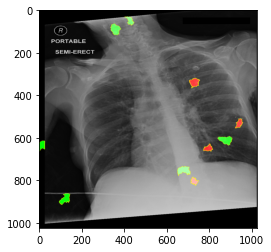

In [11]:
explainer = lime_image.LimeImageExplainer()
explain_instance(img_np, num_samples = 100)

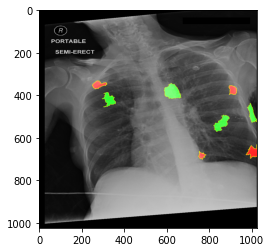

In [12]:
explain_instance(img_np, num_samples = 1000)

Might be useful for future when playing with the visualizations:

`lime.lime_image.ImageExplanation.get_image_and_mask()` documentation:

> `label` – label to explain \\
`positive_only` – if True, only take superpixels that contribute to the prediction of the label. Otherwise, use the top num_features superpixels, which can be positive or negative towards the label \\
`num_features` – number of superpixels to include in explanation \\
`hide_rest` – if True, make the non-explanation part of the return image gray]